# Data Processing TMQ

Purpose:
--------
The purpose of this notebook is to generate TMQ files from Q and PS files in order to use these processed TMQ files as input for machine learning detection of high latitude atmospheric rivers. We are specifically using 3 hourly average files covering years 2080-2100. There was previously an NCL script designed for this purpose (`/glade/campaign/cgd/amp/jet/ClimateNet/data_processing/TMQ.ncl`), but we aim to streamline our workflow by using python. This notebook calculates the pressure in each model level, then multiplies by Q and divides by gravity to calculate the mass of in each level. Then it sums all the levels to produce the TMQ field. Additionally, we optimize our workflow with dask and introduce a pythonic method of regridding.

Authors/Contributors:
---------------------
* Teagan King
* John Truesdale
* Katie Dagon
* Colin Zarzycki

## Import libraries

In [2]:
import cartopy.crs as ccrs
import cftime
from datetime import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.constants as sc
import xarray as xr

### Set up Dask

In [3]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem='25GB' # specify memory here so it duplicates below
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/$USER/local_dask', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem, # Specify resources
    project='P93300313', # Input your project ID here, previously this was known as 'project', now is 'account'
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(40)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/u/home/tking/.conda/envs/geocat_tmq/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45348 instead
  warnings.warn(


In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/45348/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/45348/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:45344,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/45348/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Calculating TMQ

### Read in files and get pressure values

In [5]:
# cat /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/tmq.ncl

In [6]:
datadir = '/glade/scratch/tking/cgnet/'
qfile_format = '*.Q.*.nc' # Q files are b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4, 3hourly avg from 2080-2100
psfile_format = '*.PS.*.nc'  # PS files are b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3, 3hourly avg from 2080-2100

qfilenames = sorted(glob.glob(datadir+qfile_format))  # sort to retain file order & ensure q and ps files match
psfilenames = sorted(glob.glob(datadir+psfile_format))

In [7]:
# qfilenames

In [8]:
# psfilenames

In [9]:
# make new .nc files but replace Q with TMQ
tmqnew_files = []
for filename in qfilenames:
    tmqnew_files.append((filename.replace('.Q.', '.TMQ.')).split('/')[-1])

In [10]:
# tmqnew_files

### Test with the first file (year 2080)

In [138]:
qfile1 = xr.open_dataset(qfilenames[0], chunks={"time": 50, "ncol": 50000}) # adjusting chunks for ~100mb size chunks
psfile1 = xr.open_dataset(psfilenames[0], chunks={"time": 50, "ncol": 50000}) # using the same chunk size for consistency

file_1_Q = qfile1['Q'] # Q at each level
file_1_PS = psfile1['PS'] # surface pressure

pref = psfile1['P0'] # reference pressure
plev = psfile1.lev

In [139]:
file_1_Q

In [140]:
file_1_PS

In [141]:
pref.values

array(100000.)

### Get hybrid level coefficients

In [142]:
psfile1['hyai']

In [143]:
psfile1['hybi']

### Calculate pressure at each level

In [144]:
plev3d=(psfile1['hyai']*pref + psfile1['hybi']*file_1_PS)
plev3d

,Array,Chunk
Bytes,524.44 GiB,591.28 MiB
Shape,"(31, 2920, 777602)","(31, 50, 50000)"
Count,3787 Tasks,944 Chunks
Type,float64,numpy.ndarray


### Calculate delta pressure at each level

In [145]:
dp3d=(plev3d[1:,:,:].drop_vars('ilev')-plev3d[:-1,:,:].drop_vars('ilev'))
#dp3d

dp3dlev=dp3d.rename({'ilev': 'lev'}) # rename level
dp3dlev

,Array,Chunk
Bytes,507.52 GiB,572.20 MiB
Shape,"(30, 2920, 777602)","(30, 50, 50000)"
Count,6619 Tasks,944 Chunks
Type,float64,numpy.ndarray


In [146]:
# assign coordinate to dimension
dp3dlev = dp3dlev.assign_coords(coords={'lev' : plev})
dp3dlev

,Array,Chunk
Bytes,507.52 GiB,572.20 MiB
Shape,"(30, 2920, 777602)","(30, 50, 50000)"
Count,6619 Tasks,944 Chunks
Type,float64,numpy.ndarray


In [147]:
# transpose to match Q
dp3dlevT = dp3dlev.transpose('time', 'lev', 'ncol')
dp3dlevT

,Array,Chunk
Bytes,507.52 GiB,572.20 MiB
Shape,"(2920, 30, 777602)","(50, 30, 50000)"
Count,7563 Tasks,944 Chunks
Type,float64,numpy.ndarray


In [148]:
# double check Q file
file_1_Q

,Array,Chunk
Bytes,253.76 GiB,286.10 MiB
Shape,"(2920, 30, 777602)","(50, 30, 50000)"
Count,945 Tasks,944 Chunks
Type,float32,numpy.ndarray


### Multiply delta pressure by Q and divide by gravity to get mass of each level

In [149]:
gravity=sc.g
gravity

9.80665

In [150]:
Qdp = file_1_Q * dp3dlevT / gravity
Qdp

,Array,Chunk
Bytes,507.52 GiB,572.20 MiB
Shape,"(2920, 30, 777602)","(50, 30, 50000)"
Count,10396 Tasks,944 Chunks
Type,float64,numpy.ndarray


### Sum over levels to get TMQ

In [151]:
tmq = Qdp.sum(dim='lev')
tmq

<xarray.DataArray (time: 2920, ncol: 777602)>
dask.array<sum-aggregate, shape=(2920, 777602), dtype=float64, chunksize=(50, 50000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol

In [152]:
# quick unit check
# pressure (Pa) = kg m^−1 s^−2
# gravity = m s^-2
# pressure / gravity = kg m^-2

## Assign some attributes to TMQ

In [153]:
tmq = tmq.assign_attrs({'long_name' : 'Total (vertically integrated) precipitable water',
                        'units' : 'kg/m2',
                        'title' : '3-hr averaged/vertically integrated/CESM Water Vapor',
                        'summary' : 'Create input for ClimateNet application',
                        'creator' : 'Teagan King, tking@ucar.edu',
                        'contact' : 'Teagan King, tking@ucar.edu',
                        'script' : 'jupyter notebook at /glade/u/home/tking/cgnet/Data_Processing.ipynb',
                        'conventions' : 'CF 1.0',
                        'creation_date' : datetime.today().strftime('%Y-%m-%d'),
                       })
tmq.name="TMQ"
tmq

<xarray.DataArray 'TMQ' (time: 2920, ncol: 777602)>
dask.array<sum-aggregate, shape=(2920, 777602), dtype=float64, chunksize=(50, 50000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    conventions:    CF 1.0
    creation_date:  2023-01-04

## Compute TMQ before writing out
Be sure to have enough memory available: in hub and dask workers. This step seems to have more failures than running tmq.compute() as part of tmq.to_netcdf().

In [154]:
# %%time
# tmq.compute()

## Save out TMQ

This is relatively quick once TMQ has been loaded into memory.

In [155]:
%%time
tmq.to_netcdf('/glade/scratch/tking/cgnet/TMQ_2080.nc', encoding = {"TMQ": {"dtype": "float32"}})

CPU times: user 43.9 s, sys: 1.5 s, total: 45.4 s
Wall time: 6min 25s


# Regrid (two methods are provided) and check output

## Regrid the file using `ncremap`

What are the memory needs for running ncremap in a notebook cell?

It may be more pythonic and streamlined within a notebook to use the map file rather than ncremap to regrid. That said, there is an option to either regrid with `ncremap` or regrid with the map file (see section below).

At the moment, regridding the entire file with ncremap may be useful, but plotting just the first time slice by regridding with the map file is recommended in order to avoid needing to read the file back in.

#TODO: optimize dask parameters for regridding with scripts in order to run more than one time slice. At the moment, the map file script method is very useful for a quick look at one time slice of the data, but ncremap may be simpler to use for regridding the entire file

In [1]:
# %%bash
# module load nco/4.7.9
# ncremap -m /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/map_ne120_to_0.23x0.31_bilinear.nc -i /glade/scratch/tking/cgnet/TMQ_2080.nc -o /glade/scratch/tking/cgnet/TMQ_2080_regrid.nc

# RCP 8.5
# TMQ_to_regrid = ['b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2080010100Z-2080123118Z.nc', 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2081010100Z-2081123118Z.nc',
# 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2082010100Z-2082123118Z.nc','b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2083010100Z-2083123118Z.nc',
# 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2084010100Z-2084123118Z.nc','b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2085010100Z-2085123118Z.nc',
# 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2086010100Z-2086123121Z.nc','b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2087010100Z-2087123121Z.nc',
# 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2088010100Z-2088123121Z.nc','b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2089010100Z-2089123121Z.nc',
# 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2090010100Z-2090123121Z.nc','b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2091010100Z-2091123121Z.nc',
# 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2092010100Z-2092123121Z.nc','b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2093010100Z-2093123121Z.nc',
# 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2094010100Z-2094123121Z.nc','b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2095010100Z-2095123121Z.nc',
# 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2096010100Z-2096123121Z.nc','b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2097010100Z-2097123121Z.nc',
# 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2098010100Z-2098123121Z.nc','b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2099010100Z-2099123121Z.nc',
# 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h4.TMQ.2100010100Z-2100123121Z.nc']

# historical
TMQ_to_regrid=['b.e13.B20TRC5CN.ne120_g16.003.cam.h3.TMQ.2000010100Z-2000123121Z.nc',
               'b.e13.B20TRC5CN.ne120_g16.003.cam.h3.TMQ.2001010100Z-2001123121Z.nc',
               'b.e13.B20TRC5CN.ne120_g16.003.cam.h3.TMQ.2002010100Z-2002123121Z.nc',
               'b.e13.B20TRC5CN.ne120_g16.003.cam.h3.TMQ.2003010100Z-2003123121Z.nc',
               'b.e13.B20TRC5CN.ne120_g16.003.cam.h3.TMQ.2004010100Z-2004123121Z.nc',
               'b.e13.B20TRC5CN.ne120_g16.003.cam.h3.TMQ.2005010100Z-2005123121Z.nc']

for file in TMQ_to_regrid:
    print('ncremap -m /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/map_ne120_to_0.23x0.31_bilinear.nc -i {} -o /glade/scratch/tking/cgnet/historical_2000_2005/regridded_TMQ/{}'.format(file, file))

# update batch script (batch_psl_remap.sh) in /scripts directory to use your email, project number, TMQ variable, preferred job name, etc
# update relevant script (psl_remap_script) in /scripts directory to include correct filenames (eg, replace current script with output from this cell that use your filenames)
# run these commands from casper terminal with `qsub <batch_script_name>`

ncremap -m /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/map_ne120_to_0.23x0.31_bilinear.nc -i b.e13.B20TRC5CN.ne120_g16.003.cam.h3.TMQ.2000010100Z-2000123121Z.nc -o /glade/scratch/tking/cgnet/historical_2000_2005/regridded_TMQ/b.e13.B20TRC5CN.ne120_g16.003.cam.h3.TMQ.2000010100Z-2000123121Z.nc
ncremap -m /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/map_ne120_to_0.23x0.31_bilinear.nc -i b.e13.B20TRC5CN.ne120_g16.003.cam.h3.TMQ.2001010100Z-2001123121Z.nc -o /glade/scratch/tking/cgnet/historical_2000_2005/regridded_TMQ/b.e13.B20TRC5CN.ne120_g16.003.cam.h3.TMQ.2001010100Z-2001123121Z.nc
ncremap -m /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/map_ne120_to_0.23x0.31_bilinear.nc -i b.e13.B20TRC5CN.ne120_g16.003.cam.h3.TMQ.2002010100Z-2002123121Z.nc -o /glade/scratch/tking/cgnet/historical_2000_2005/regridded_TMQ/b.e13.B20TRC5CN.ne120_g16.003.cam.h3.TMQ.2002010100Z-2002123121Z.nc
ncremap -m /glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps

In [30]:
# # Read back in for plotting
# fn=('/glade/scratch/tking/cgnet/TMQ_2080_regrid.nc')
# dstmq=xr.open_dataset(fn, chunks={"time": 20}) # adjust for chunk size ~100MB

In [31]:
# dstmq.TMQ

<xarray.DataArray 'TMQ' (time: 2920, lat: 768, lon: 1152)>
dask.array<open_dataset-4464f2a895dbe572f6cbf340c7bfd69fTMQ, shape=(2920, 768, 1152), dtype=float64, chunksize=(20, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    summary:        Create input for ClimateNet application, Poisson Fill for...
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    conventions:    CF 1.0
    creation_date:  2022-12-20
    cell_measures:  area: area

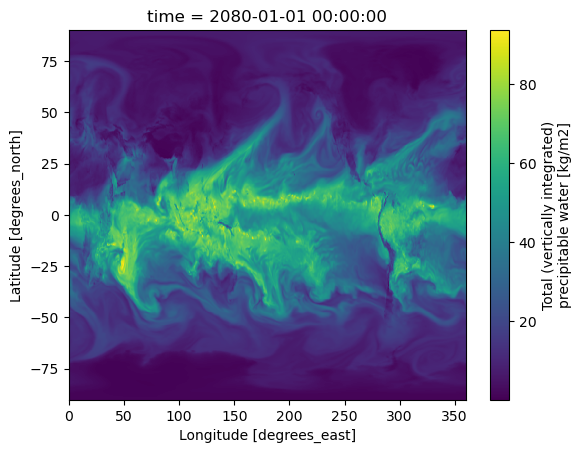

In [32]:
# # Quick plot of first time index
# dstmq['TMQ'].isel(time=0).plot();

/glade/u/home/tking/.conda/envs/geocat_tmq/lib/python3.10/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/tking/.conda/envs/geocat_tmq/lib/python3.10/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/u/home/tking/.conda/envs/geocat_tmq/lib/python3.10/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/glade/u/h

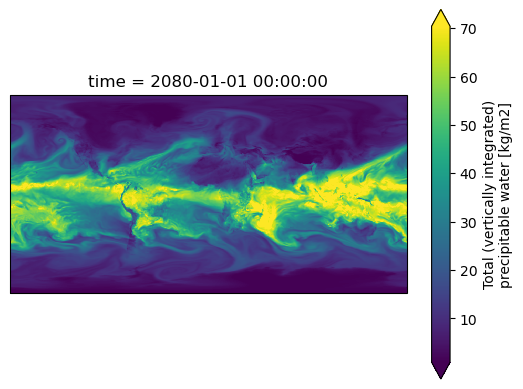

In [33]:
# ax=plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# dstmq['TMQ'].isel(time=0).plot(transform=ccrs.PlateCarree(),robust=True);

## Regrid TMQ using map file for quick look in pythonic manner without reading in file

See notes on some pros and cons of this method in the first regridding section above.

From Colin Zarzycki, 12/8/22, and updated for this particular scenario by Katie Dagon

https://github.com/UXARRAY/uxarray/issues/183

In [38]:
## ESMF weightfile
map_path = '/glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/'
map_file='map_ne120_to_0.23x0.31_bilinear.nc'
xwgt=xr.open_dataset(map_path+map_file)
xwgt

<xarray.Dataset>
Dimensions:        (src_grid_rank: 1, dst_grid_rank: 2, n_a: 777602, n_b: 884736, nv_a: 3, nv_b: 4, n_s: 2654208)
Dimensions without coordinates: src_grid_rank, dst_grid_rank, n_a, n_b, nv_a, nv_b, n_s
Data variables: (12/19)
    src_grid_dims  (src_grid_rank) int32 ...
    dst_grid_dims  (dst_grid_rank) int32 ...
    yc_a           (n_a) float64 ...
    yc_b           (n_b) float64 ...
    xc_a           (n_a) float64 ...
    xc_b           (n_b) float64 ...
    ...             ...
    area_b         (n_b) float64 ...
    frac_a         (n_a) float64 ...
    frac_b         (n_b) float64 ...
    col            (n_s) int32 ...
    row            (n_s) int32 ...
    S              (n_s) float64 ...
Attributes:
    title:               ESMF Offline Regridding Weight Generator
    normalization:       destarea
    map_method:          Bilinear remapping
    ESMF_regrid_method:  Bilinear
    conventions:         NCAR-CSM
    domain_a:            /glade/p/cgd/ccr/people/nanr/mapfiles/ne120.nc
    domain_b:            /glade/p/cgd/ccr/people/nanr/mapfiles/0.23x0.31.nc
    grid_file_src:       /glade/p/cgd/ccr/people/nanr/mapfiles/ne120.nc
    grid_file_dst:       /glade/p/cgd/ccr/people/nanr/mapfiles/0.23x0.31.nc
    CVS_revision:        6.3.0r

In [39]:
srclat=xwgt['yc_a']
srclon=xwgt['xc_a']
dstlat=xwgt['yc_b']
dstlon=xwgt['xc_b']
src_grid_dims=xwgt['src_grid_dims'].values
dst_grid_dims=xwgt['dst_grid_dims'].values

print("Src grid dims: {0}, dst grid dims: {1}".format(src_grid_dims, dst_grid_dims))

n_a = xwgt['n_a'].size # col dimension
n_b = xwgt['n_b'].size # row dimension
n_s = xwgt['n_s'].size # nnz dimension

print("Map contains {0} rows, {1} cols and {2} nnz values".format(n_b, n_a, n_s))

rows = xwgt['row'][:] - 1 # row indices (1-based)
cols = xwgt['col'][:] - 1 # col indices (1-based)
nnzvals = xwgt['S'][:] # nnz map values

Src grid dims: [777602], dst grid dims: [1152  768]
Map contains 884736 rows, 777602 cols and 2654208 nnz values


In [40]:
## Create sparse matrix map
sparse_map = sp.sparse.coo_matrix((nnzvals, (rows,cols)),shape=(n_b,n_a))
sparse_map

<884736x777602 sparse matrix of type '<class 'numpy.float64'>'
	with 2654208 stored elements in COOrdinate format>

Note this is the time consuming step, so sticking to one time index for now

In [48]:
%%time
## Now apply map onto a src column vector length n_a to compute vector length n_b
field_target = sparse_map @ tmq.isel(time=0)

CPU times: user 5.28 s, sys: 286 ms, total: 5.56 s
Wall time: 1min 4s


In [42]:
## Reshape 1-D vector returned to dst_grid_dims
data_out = np.reshape(field_target, dst_grid_dims, order='F')
print("Reshaped array now has dimensions {0}".format(dst_grid_dims, n_a, n_s))

Reshaped array now has dimensions [1152  768]


In [43]:
## Reshape destination grid to build structured xarray da
lat2d = np.reshape(dstlat.values, dst_grid_dims, order='F')
lon2d = np.reshape(dstlon.values, dst_grid_dims, order='F')

In [44]:
## Build da
da = xr.DataArray(
    data=data_out,
    dims=["x", "y"],
    coords=dict(
        lon=(["x"], lon2d[:,0]),
        lat=(["y"], lat2d[0,:]),
    )
)

In [45]:
da

<xarray.DataArray (x: 1152, y: 768)>
array([[1.1169718 , 1.1214458 , 1.13117935, ..., 7.07744253, 7.20029686,
        7.33181943],
       [1.1169718 , 1.12127458, 1.13083692, ..., 7.0774965 , 7.20032384,
        7.33181943],
       [1.1169718 , 1.12110307, 1.13049391, ..., 7.07755778, 7.20035448,
        7.33181943],
       ...,
       [1.1169718 , 1.12170537, 1.1316985 , ..., 7.07665856, 7.19990485,
        7.33181943],
       [1.1169718 , 1.12161914, 1.13152604, ..., 7.07691256, 7.20003186,
        7.33181943],
       [1.1169718 , 1.12153262, 1.13135299, ..., 7.07717389, 7.20016253,
        7.33181943]])
Coordinates:
    lon      (x) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
    lat      (y) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
Dimensions without coordinates: x, y

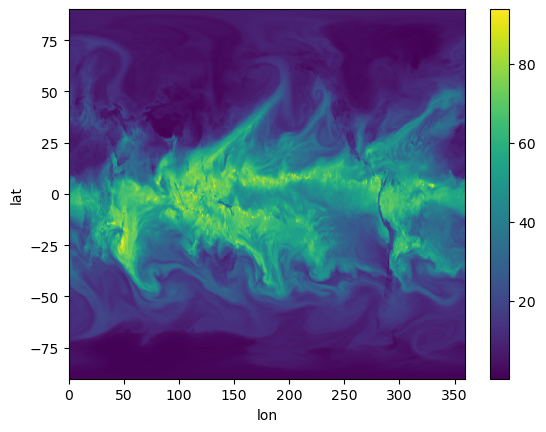

In [46]:
## Simple plot
da.plot(x="lon", y="lat")